In [1]:
from pickletools import optimize
from tabnanny import verbose
import unittest
from venv import create
from keras import Optimizer, activations
from keras.src.layers import RandomTranslation
import numpy as np
from numpy import *
import pickle
from fileinput import *
import os
from tkinter import *
import tensorflow as tf
import matplotlib.pyplot as mp
from tensorflow.python import *
import tf2onnx
import onnx
from onnx2pytorch import ConvertModel

## The Crux of the details below
Implementing the Horses vs Humans dataset
Using image size of 300 x 300
Using Kernel size as 5 x 5
Using 13 CCN layers with relu activcation
Using MaxPooling with 2 x 2
Using 3 FC layers

Now, we create the path using the __OS class. 

In [2]:
BASE_dir = './horse-or-human'
data_dir_horse = os.path.join(BASE_dir, 'horses')
data_dir_human = os.path.join(BASE_dir, 'humans')
print(f"Printing total images for each set")
print(f"There are {len(os.listdir(data_dir_horse))} images of horses")
print(f"There are {len(os.listdir(data_dir_human))} images of humans")

Printing total images for each set
There are 500 images of horses
There are 527 images of humans


Printing the dataset for visuality

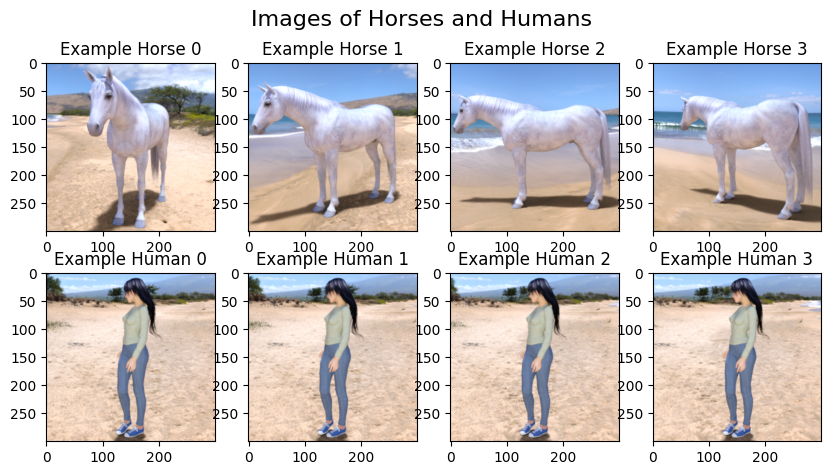

In [3]:
horse_filenames =[os.path.join (data_dir_horse, filename) for filename in os.listdir(data_dir_horse)]
human_filenames =[os.path.join (data_dir_human, filename) for filename in os.listdir(data_dir_human)]
fig, axes = mp.subplots(2, 4, figsize=(10, 5))
fig.suptitle('Images of Horses and Humans', fontsize= 16)
#Using MP as PLT
for i, horse_img in enumerate (horse_filenames[:4]):
    img = tf.keras.utils.load_img (horse_img)
    axes[0, i].imshow(img)#printed
    axes[0, i].set_title(f'Example Horse {i}')#printed
for i, human_img in enumerate (human_filenames[:4]):
    img = tf.keras.utils.load_img (human_img)
    axes[1, i].imshow(img)#printed
    axes[1, i].set_title(f'Example Human {i}')#printed
mp.show()

## Train vs Val Split cell
Now we would split our data into 2 categories. We would use 10% for validation.\
The images size use is 150, 150
Batch size preferred is __32 becuase of better rendering of the images
Label Model used if __binary
Validation split is __20%

In [36]:
def train_val_datasets():
    """
    To create datasets for training and validation.
    Should we use folders to specify each?
    Lets see
       Returns:
        (tf.data.Dataset, tf.data.Dataset): Training and validation datasets.
    """
    train_dataset,val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory = BASE_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = "binary",
    validation_split = 0.2,
    subset = "both",
    seed = 40
    )
    return train_dataset, val_dataset
print(f"Seperating Training and Validation dataset")
train_dataset, val_dataset = train_val_datasets()
for images, labels in train_dataset.take(1):
    example_batch_images = images
    example_batch_labels = labels
print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}\n")
print(f"Shape of batch of labels: {example_batch_labels.shape}\n")

Seperating Training and Validation dataset
Found 1027 files belonging to 2 classes.
Using 822 files for training.
Using 205 files for validation.
Maximum pixel value of images: 255.0

Shape of batch of images: (32, 150, 150, 3)

Shape of batch of labels: (32, 1)



## Comments about the Dataset
We can see that there are a number of different angles and zoom that are availble in our dataset. We would now also create augmnented data for our kernel to use different classes.
### Augmented dataset
We would change our total dataset's 20% images into variations for the model to understand and better detect an object. Soon, we will also bring multiclass as well.

## Creating the model
Now we would create the model and add the augmentation for better visualization of the dataset
The optimization algorithm used if the RMS prop

In [52]:
def cr_aug_mod():
    """Creates a model (layers stacked on top of each other) for augmenting images of cats and dogs.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images of cats and dogs.
    """
    data_augmentation =tf.keras.Sequential ([
        tf.keras.Input(shape=(150,150,3)),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.15, fill_mode='nearest'),
        tf.keras.layers.RandomTranslation(0.15, 0.15, fill_mode='nearest'),
        tf.keras.layers.RandomZoom(0.15, fill_mode='nearest')    
        ]) 
    return data_augmentation


def cr_model():#create after consulting research papers
    """
    Classification of horses and humans
    Returns:
      tf.keras.Model: The model that will be trained to classify cats and dogs.
    """
    augmentation_layers = cr_aug_mod()
    
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150,150,3)),
        augmentation_layers,
        tf.keras.layers.Rescaling(scale=1./255),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
        tf.keras.layers.Conv2D(32,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),#hidden units
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile( 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy'] 
    ) 
    model.summary()
    return model

Lets visualize our data

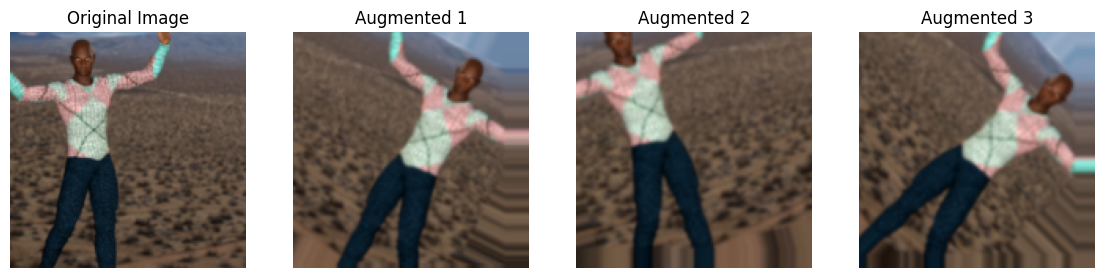

In [53]:
visu = cr_aug_mod()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = visu(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = mp.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

mp.show()

## Running the model
Now lets get down to business
We will use the history class to define the loss, accuracy and the overall output of our model

In [54]:
def plot_loss_acc(history):
    """
    For validation and train dataset accuracy
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = mp.subplots(1, 2, figsize = (12,6))
    ax[0].plot(epochs, acc, 'bo', label='Training Accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
    ax[0].set_title('Training and Validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()


    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and Validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')
    ax[1].legend()

    mp.show()

In [55]:
augmented_model = cr_model()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)   │ (None, 150, 150, 3)   │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ rescaling_5 (Rescaling)      │ (None, 150, 150, 3)   │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_44 (Conv2D)           │ (None, 148, 148, 32)  │          896 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_45 (Conv2D)           │ (None, 146, 146, 32)  │        9,248 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_18             │ (None, 73, 73, 32)    │            0 │
│ (MaxPooling2D)               │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_46 (Conv2D)           │ (None, 71, 71, 64)    │       18,496 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_47 (Conv2D)           │ (None, 69, 69, 64)    │       36,928 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_19             │ (None, 34, 34, 64)    │            0 │
│ (MaxPooling2D)               │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_48 (Conv2D)           │ (None, 32, 32, 128)   │       73,856 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_49 (Conv2D)           │ (None, 30, 30, 128)   │      147,584 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_50 (Conv2D)           │ (None, 28, 28, 128)   │      147,584 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_20             │ (None, 14, 14, 128)   │            0 │
│ (MaxPooling2D)               │                       │              │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_5 (Flatten)          │ (None, 25088)         │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_16 (Dense)             │ (None, 512)           │   12,845,568 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_6 (Dropout)          │ (None, 512)           │            0 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_17 (Dense)             │ (None, 512)           │      262,656 │
├──────────────────────────────┼───────────────────────┼──────────────┤
│ dense_18 (Dense)             │ (None, 1)             │          513 │
└──────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 13,543,329 (51.66 MB)

 Trainable params: 13,543,329 (51.66 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
#now compiling model
EPOCHS = 20
print(f"Model executed")
history = augmented_model.fit(
    train_dataset,
    epochs=EPOCHS,
    verbose=2,
    validation_data=val_dataset
    )

Model executed
Epoch 1/20
26/26 - 15s - 586ms/step - accuracy: 0.4708 - loss: 0.6950 - val_accuracy: 0.5610 - val_loss: 0.6897
Epoch 2/20
26/26 - 13s - 505ms/step - accuracy: 0.5523 - loss: 0.7022 - val_accuracy: 0.5951 - val_loss: 0.6875
Epoch 3/20
26/26 - 13s - 503ms/step - accuracy: 0.6083 - loss: 0.6876 - val_accuracy: 0.5707 - val_loss: 0.6687
Epoch 4/20
26/26 - 13s - 504ms/step - accuracy: 0.6350 - loss: 0.6579 - val_accuracy: 0.7561 - val_loss: 0.5353
Epoch 5/20
26/26 - 13s - 515ms/step - accuracy: 0.6800 - loss: 0.6366 - val_accuracy: 0.7561 - val_loss: 0.4850
Epoch 6/20
26/26 - 13s - 516ms/step - accuracy: 0.7311 - loss: 0.5549 - val_accuracy: 0.7512 - val_loss: 0.5034
Epoch 7/20
26/26 - 13s - 516ms/step - accuracy: 0.7263 - loss: 0.5476 - val_accuracy: 0.7610 - val_loss: 0.7111
Epoch 8/20
26/26 - 14s - 521ms/step - accuracy: 0.7628 - loss: 0.4790 - val_accuracy: 0.8244 - val_loss: 0.3815
Epoch 9/20
26/26 - 13s - 516ms/step - accuracy: 0.7944 - loss: 0.4126 - val_accuracy: 0.8

## Resutls
### Model Speed
Model speed at image size 150x150, batch size 32 and kernel size 3x3 is fastest. EPOCH size can be increased for higher accuracy. 
### Accuracy and Validation
We achieved an astounding accuracy of 0.94 and validation of 0.95
### Loss
training loss = 0.15, validation loss = 0.11
## Visualizing results
Lets plot the results for better understanding

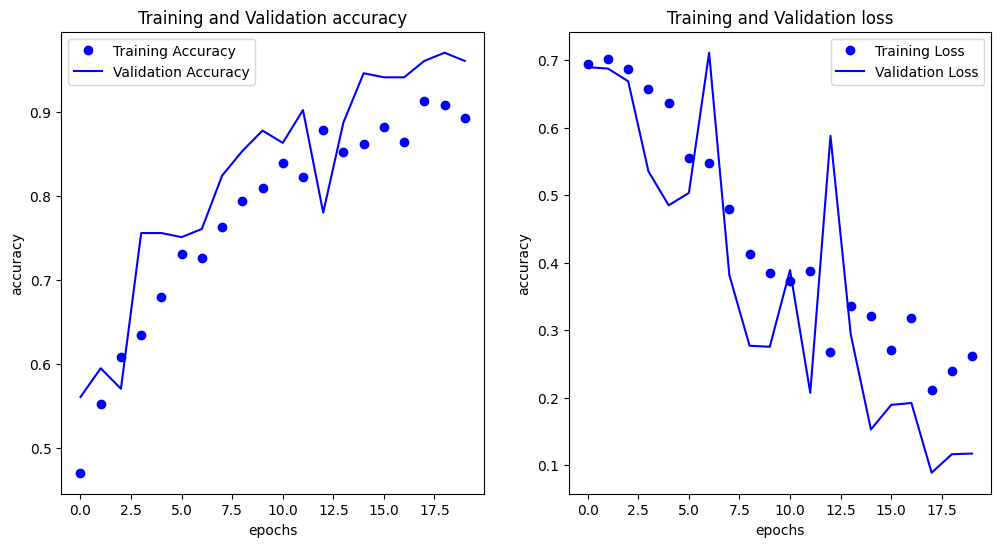

In [57]:
plot_loss_acc(history)

We have generally achieved a strong and fundamentally superior method of object detection.\
Now we save the model for use in multiclass functions

In [58]:
augmented_model.save('horses_v_humans.keras')

## Using Pytorch
We can convert our model to pytorch to save alot of time of our processing and play with the results for further ammendments.
### Code
augmented_model_name = "obj_dec_cnn"
input_signature = [tf.TensorSpec(augmented_model.inputs[0].shape, augmented_model.inputs[0].dtype, name='digit')]
augmented_model.output_names =['output'] 
model_fast, _ = tf2onnx.convert.from_keras(augmented_model, input_signature)
model_pytorch = ConvertModel(model_fast)